<a href="https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn?scriptVersionId=125681512" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [1]:
#  ! pip install imutils -q

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

from datetime import datetime
import uuid


def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    


# FULL PROGRAM BELOW
> Program dibawah ini digunakan untuk menghasilkan dataset karakter dari poto plat motor yang telah diambil. setelah program menghasilkan karakter plat, perlu dilakukan `zip` secara manual untuk mendownload hasilnya.

In [13]:
# gunakan cell ini untuk mendownload dataset yang telah dihasilkan
! ls @*

@outputDataset.zip


In [10]:
indeximg=0
filepath=[]
for root, dirname, filename in os.walk('/kaggle/input/haarcascadeplatenumber'):
    for file in filename:
        filepath.append(os.path.join(root, file))

In [11]:
for ra in range(0, len(filename)):
    img = cv2.imread(filepath[indeximg])

    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    blured  = cv2.GaussianBlur(hisimg, (21,21), 0) 
    edged   = cv2.Canny(blured, 10, 180)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    dilate = cv2.dilate(edged, kernel, iterations=1)

    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_copy = img.copy()
    cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

    platno=[]
    index=0

    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = w/h

        if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
            print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
            platno.append(index)
        index += 1
    print(f'detected plat no: {len(platno)}, index: {indeximg}')


    if len(platno)>0:
        try:

            for plat in platno:
                detectedimg = img.copy()
                x,y,w,h = cv2.boundingRect(contours[plat])
                croppedimg = img[y: y+h, x:x+w]

            ##########################################################################

                grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
                hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
                blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
                edged   = cv2.Canny(blured, 10, 120)

                kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                dilate = cv2.dilate(edged, kernel, iterations=1)

                contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
                image_copy = croppedimg.copy()
                imgrec = croppedimg.copy()

                platno=[]
                index=0
                realPlatno=0

                for contour in contours:
                    x,y,w,h = cv2.boundingRect(contour)
                    aspect_ratio = w/h
                    luas = w*h

                    if w > 100 and h>=150 and h <410 and aspect_ratio <= 0.7 :
                        platno.append(index)
                        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
                        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
                        realPlatno+=1
                    index += 1
                print(f'detected candidate plat no: {len(platno)}')

                urutx = []
                for char in platno:
                    x,y,w,h = cv2.boundingRect(contours[char])
                    urutx.append(x)
                urutx = sorted(urutx)

                ## urutkan karakter plat nomor dari kiri ke kanan
                cropCharUrut=[]
                for ux in urutx:
                    for char in platno :
                        x,y,w,h = cv2.boundingRect(contours[char])
                        if x == ux: 
                            cropCharUrut.append(char)
                            break
                o = 0
                for c in cropCharUrut:
                    x,y,w,h = cv2.boundingRect(contours[c])
                    o=0
                    for i in cropCharUrut:
                        if c==i:
                            continue
                        x2,y2,w2,h2 = cv2.boundingRect(contours[i])

                        if abs(x-x2) < 10:
                            cropCharUrut.pop(o)
                        o+=1
                print(cropCharUrut)

                for c in cropCharUrut:
                    x,y,w,h = cv2.boundingRect(contours[c])
                    cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)

#                 display(imgrec, "box plat no")

                ##########################################################################

                # tampilkan karakter yang telah terpotong
                imgs=[]
                savepath='/kaggle/working/'
                imgHeight = 40
                imgWidth  = 40

                for char in cropCharUrut:
                    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
                    filename = os.path.join(savepath, filename)
                    print(filename)

                    x,y,w,h = cv2.boundingRect(contours[char])
                    crop = grayimg[y: y+h, x:x+w]
                    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
                    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
                    imgs.append(char_crop)
                    cv2.imwrite(filename, char_crop)
#                     display(char_crop)

        except:
            pass

    # increment indeximg
    indeximg +=1

aspect ratio from index: 5924, 1.7028169014084507, w: 1209, h: 710
detected plat no: 1, index: 0
x: 920, y: 454, w: 105, h: 152
x: 1046, y: 444, w: 106, h: 152
x: 228, y: 144, w: 126, h: 248
x: 231, y: 146, w: 120, h: 243
x: 374, y: 142, w: 129, h: 247
x: 512, y: 123, w: 138, h: 241
x: 514, y: 125, w: 134, h: 237
x: 856, y: 85, w: 156, h: 262
x: 858, y: 87, w: 151, h: 257
x: 1014, y: 65, w: 144, h: 264
detected candidate plat no: 10
[93, 98, 103, 109, 46, 114, 51]
/kaggle/working/12_04_2023-00_24_4673f38f71-87d8-46f9-bf96-87249df817a8.jpg
/kaggle/working/12_04_2023-00_24_46ccac73b6-29de-484c-9df0-8954193f6d1f.jpg
/kaggle/working/12_04_2023-00_24_46e958fd3a-0086-4c1d-8a85-510f6db6b8ca.jpg
/kaggle/working/12_04_2023-00_24_4660b32e86-e7f9-46d7-a2d8-db065a84e364.jpg
/kaggle/working/12_04_2023-00_24_46f4da83d0-d5f4-4006-9204-413cdecc2f31.jpg
/kaggle/working/12_04_2023-00_24_4644221644-5fa3-44d7-98c4-9e2973bef4dc.jpg
/kaggle/working/12_04_2023-00_24_4689d336d0-1db5-4668-a2b8-8e4301ce163a.jpg

# PROGRAM DIBAWAH INI DIGUNAKAN UNTUK MELAKUKAN PREDIKSI PLAT MOTOR 

# program untuk mendeteksi digit dari plat nomor motor

In [119]:
def potongKarakter():
    imgs.clear()
    grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
    hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
    edged   = cv2.Canny(blured, 10, 120)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    dilate = cv2.dilate(edged, kernel, iterations=1)

    contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    image_copy = croppedimg.copy()
    imgrec = croppedimg.copy()

    platno=[]
    index=0
    realPlatno=0
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = w/h
        luas = w*h

        if w > 120 and h>=150 and h <410 and aspect_ratio <= 0.7 :
            platno.append(index)
            cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
    #         print(f'x: {x}, y: {y}, w: {w}, h: {h}')
            realPlatno+=1
        index += 1
    # print(f'detected candidate plat no: {len(platno)}')

    urutx = []
    for char in platno:
        x,y,w,h = cv2.boundingRect(contours[char])
        urutx.append(x)
    urutx = sorted(urutx)

    ## urutkan karakter plat nomor dari kiri ke kanan
    cropCharUrut=[]
    for ux in urutx:
        for char in platno :
            x,y,w,h = cv2.boundingRect(contours[char])
            if x == ux: 
                cropCharUrut.append(char)
                break
    o = 0
    for c in cropCharUrut:
        x,y,w,h = cv2.boundingRect(contours[c])
        o=0
        for i in cropCharUrut:
            if c==i:
                continue
            x2,y2,w2,h2 = cv2.boundingRect(contours[i])

            if abs(x-x2) < 10:
                cropCharUrut.pop(o)
            o+=1
    # print(cropCharUrut)

    for c in cropCharUrut:
        x,y,w,h = cv2.boundingRect(contours[c])
        cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)
    
    imgHeight = 40
    imgWidth  = 40

    for char in cropCharUrut:
        x,y,w,h = cv2.boundingRect(contours[char])
        crop = grayimg[y: y+h, x:x+w]
        ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
        char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
        imgs.append(char_crop)
        
    display(imgrec, "box plat no")


In [120]:
def cobaTebak():
    predictedPlat=[]
    predictedPlat.clear()
    for index in range(0, len(imgs)):
        image1 =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
        char_crop = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)

        # resize citra karakternya
        char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
    #     display(char_crop)

        # preprocessing citra ke numpy array
        img_array = keras.preprocessing.image.img_to_array(char_crop)
        # agar shape menjadi [1, h, w, channels]
        img_array = tf.expand_dims(img_array, 0)

        pred = model.predict(img_array)
        score = tf.nn.softmax(pred[0])

    #     print(class_names[np.argmax(score)])
    #     ax.imshow(image)
        predictedPlat.append(class_names[np.argmax(score)])
#         print(predictedPlat)

    label=""
    label=label.join(predictedPlat)
    print(label)
    cv2.putText(image, label, org, cv2.FONT_HERSHEY_SIMPLEX, 10, (0,0,255), 15, cv2.LINE_AA)

    display(image)

TERDETEKSI 2 BUAH PLAT NOMOR


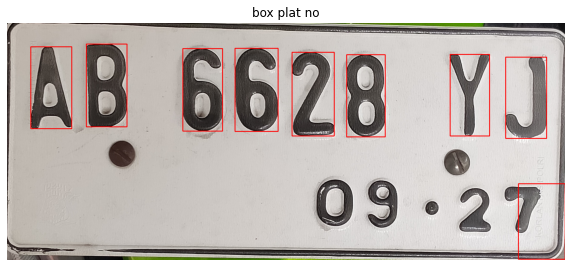

AB6628YJD


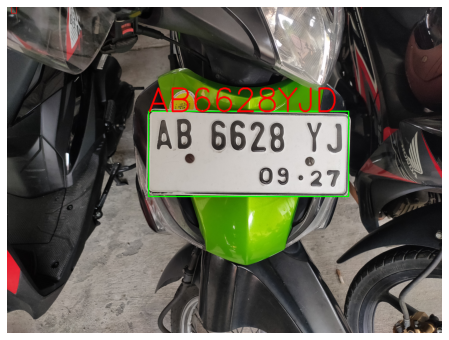

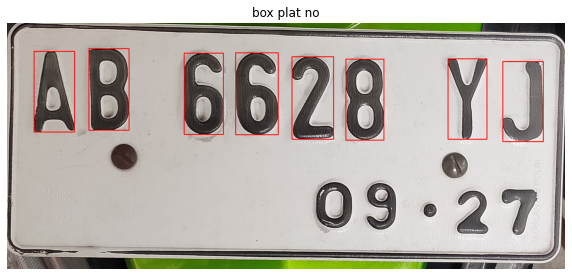

AB6628YJ


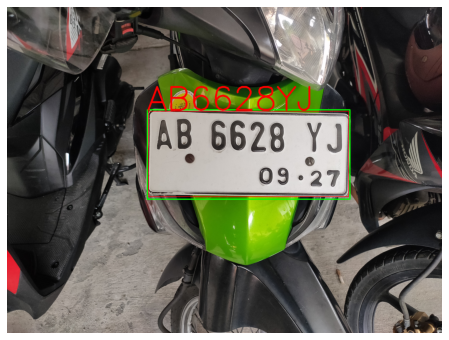

In [131]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/dataset/AB6628YJ.jpg')
model = keras.models.load_model('/kaggle/working/my_model')

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# predictedPlat=[]

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (21,21), 0) 
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
#         print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
        platno.append(index)
    index += 1
# print(f'detected plat no: {len(platno)}, index: {indeximg}')

imgs=[]
if len(platno)>0:
    print(f'TERDETEKSI {len(platno)} BUAH PLAT NOMOR')
    for plat in platno:
        image = cv2.rectangle(img.copy(), (x,y), (x+w,y+h), (0,0,255),3)
        detectedimg = img.copy()
        x,y,w,h = cv2.boundingRect(contours[plat])
        croppedimg = img[y: y+h, x:x+w]
        
        #buat gambar baru untuk menampilkan hasil
        image = cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0),10)
#         display(image)
        org = (x, y)
#         display(croppedimg)
        
        #lakukan pemtongan karakter plat nomor
        potongKarakter()
        
        #lakukan klasifikasi dari karakter yang didapatkan 
        cobaTebak()
        
else:
    print("TIDAK TERDETEKSI PLAT NOMOR")
        

# program dibawah ini digunakan untuk menyimpan karakter yang sudah terpotong ke output directory

In [ ]:
from datetime import datetime
import uuid

# tampilkan karakter yang telah terpotong
imgs=[]
savepath='/kaggle/working/'
imgHeight = 40
imgWidth  = 40

for char in cropCharUrut:
    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
    filename = os.path.join(savepath, filename)
    print(filename)
    
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
    imgs.append(char_crop)
#     cv2.imwrite(filename, crop)
    display(char_crop)


# Buat Model Untuk Klasifikasi 

In [52]:
"""
Cell nggone AH... Ojo diubah ubah
Buat Model dari tutorial:
https://www.tensorflow.org/tutorials/images/classification
"""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

path = '/kaggle/input/haarcascadeplatenumber/DatasetCharacter/DatasetCharacter'

batchSize = 32
imgHeight = 40
imgWidth  = 40

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize )

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize )

className = trainDs.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valDs.cache().prefetch(buffer_size=AUTOTUNE)

numClass = len(className)

# buat model dengan tensorflow sequential
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClass)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model.summary()

Found 37234 files belonging to 36 classes.
Using 29788 files for training.
Found 37234 files belonging to 36 classes.
Using 7446 files for validation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None,

In [53]:
epochs=10
history = model.fit(trainDs,
                    validation_data = valDs,
                    epochs=epochs)

Epoch 1/10
931/931 [==============================] - 126s 135ms/step - loss: 0.5609 - accuracy: 0.8550 - val_loss: 0.2787 - val_accuracy: 0.9245
Epoch 2/10
931/931 [==============================] - 60s 64ms/step - loss: 0.1893 - accuracy: 0.9483 - val_loss: 0.2380 - val_accuracy: 0.9307
Epoch 3/10
931/931 [==============================] - 60s 64ms/step - loss: 0.1217 - accuracy: 0.9638 - val_loss: 0.1492 - val_accuracy: 0.9586
Epoch 4/10
931/931 [==============================] - 62s 67ms/step - loss: 0.0880 - accuracy: 0.9745 - val_loss: 0.1487 - val_accuracy: 0.9607
Epoch 5/10
931/931 [==============================] - 61s 65ms/step - loss: 0.0649 - accuracy: 0.9813 - val_loss: 0.1360 - val_accuracy: 0.9641
Epoch 6/10
931/931 [==============================] - 58s 62ms/step - loss: 0.0466 - accuracy: 0.9871 - val_loss: 0.1244 - val_accuracy: 0.9682
Epoch 7/10
931/931 [==============================] - 58s 62ms/step - loss: 0.0395 - accuracy: 0.9889 - val_loss: 0.1284 - val_accurac

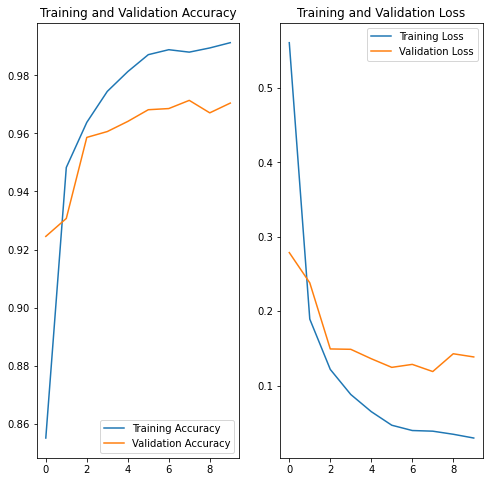

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('my_model') # Save trained model

In [56]:
# model = keras.models.load_model('/kaggle/working/my_model')

# display(imgs[index])
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
predictedPlat=[]


for index in range(0, len(imgs)):
    image =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    char_crop = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # resize citra karakternya
    char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
#     display(char_crop)

    # preprocessing citra ke numpy array
    img_array = keras.preprocessing.image.img_to_array(char_crop)
    # agar shape menjadi [1, h, w, channels]
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])

#     print(class_names[np.argmax(score)])
#     ax.imshow(image)
    predictedPlat.append(class_names[np.argmax(score)])

# image = cv2.putText(img.copy, 'OpenCV', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    
# plt.imshow(labeledImg)
    
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,predictedPlat,fontsize=30,ha='center')
plt.show()

NameError: name 'imgs' is not defined

satu


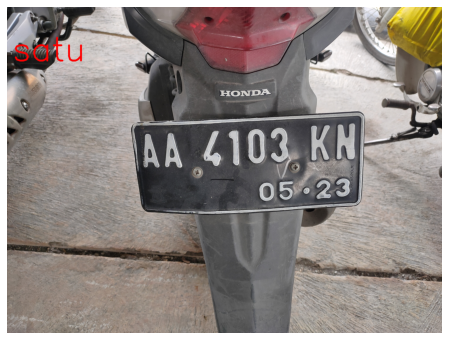

In [23]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/dataset/AA4103KN.jpg')

s = ['s', 'a', 't', 'u']
label = ""
label = label.join(s)
print(label)

image = cv2.putText(img, label, (50,500), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,0,255), 15, cv2.LINE_AA)
display(image)